# Predict Advert Click
## Author: Thomas Bahng

Predict which users are likely to click a particular advertisement and explain how different features affect the prediction. 

SearchMe is an Internet giant and search engine company that earns the majority of its revenue through online advertising. Their aim is to maximize the number of clicks their advertisements generate. Management has decided to investigate which users are more likely to click a particular advertisement. They want to analyze which factors affect this the most. This will not only help to increase the engagement but will also help in user profiling.

In [708]:
# data manipulation
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 101)

# feature selection
# https://www.kaggle.com/ar2017/basics-of-feature-selection-with-python
from sklearn.feature_selection import RFE, mutual_info_classif

# logistic regression analysis
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# data scaling
from sklearn.preprocessing import scale

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns

# text analysis
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import re
from cleantext import clean

# model deployment
import pickle
from sklearn.pipeline import Pipeline

# unsupervised learning
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# impute missing values
from sklearn.impute import KNNImputer

# chi-square test
from scipy.stats import chi2_contingency

## Data Description

Column | Description
:---|:---
`id` | Unique id
`Daily Time Spent on Site` | Consumer time spent on site (in minutes)
`Age` | Consumer age (in years)
`Area Income` | Avg. Income of geographical area of consumer (in US $$)
`Daily Internet Usage` | Avg. minutes a day consumer is on the internet
`Ad Topic Line` | Headline of the advertisement
`gender` | Gender of the consumer
`Country` | Country of consumer
`Timestamp` | Timestamp at which consumer clicked on Ad or closed window (YYYY-MM-DD HH:MM:SS)
`Clicked` | Whether a consumer clicked on the advert or not (0: No ,1: Yes)

## Data Wrangling & Visualization

In [562]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")
print("Train data shape:", data.shape)
data.head()

Train data shape: (1000, 10)


,id,Timestamp,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,gender,Country,Clicked
0,1200,2016-01-01 02:52:10,80.67,34,58909.36,239.76,Seamless impactful info-mediaries,0,Portugal,0
1,1201,2016-01-01 03:35:35,68.01,25,68357.96,188.32,Ameliorated actuating workforce,1,Afghanistan,0
2,1202,2016-01-01 05:31:22,80.94,36,60803.00,239.94,Self-enabling local strategy,0,Bermuda,0
3,1203,2016-01-01 08:27:06,78.77,28,63497.62,211.83,Public-key intangible Graphical User Interface,0,Guam,0
4,1204,2016-01-01 15:14:24,36.56,29,42838.29,195.89,Team-oriented bi-directional secured line,0,Uganda,1


The training set consists of 1000 observations of the 10 variables shown above. Since id is not a variable, we will set it as the index.

In [563]:
data.set_index('id', inplace=True)

In [564]:
#Explore columns
data.dtypes

Timestamp                    object
Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
gender                        int64
Country                      object
Clicked                       int64
dtype: object

Predictor variables consist of datetime, float, integer, and strings.

### Missing Values

In [565]:
# percent missing values assessment
data.isna().sum() / data.shape[0]

Timestamp                   0.000
Daily Time Spent on Site    0.000
Age                         0.000
Area Income                 0.225
Daily Internet Usage        0.000
Ad Topic Line               0.000
gender                      0.000
Country                     0.000
Clicked                     0.000
dtype: float64

Approximtely 22% of Daily Internet Usage has missing values. Per the definition above, this variable represents the average income of the geographical area in which the consumer resides.

### Feature Extraction
The Timestamp of when the Clicked event occurred can provide additional features such as Quarter, Day of Week or Time of Day. Once we've extracted these features from Timestamp, we no longer need this variable as it won't be used as a predictor.

In [566]:
# time stamp 2016-01-01 15:14:24
# create day-of-week and time-of-day variable
date_pattern='%Y-%m-%d'
time_pattern='%H:%M:%S'
full_pattern = ' '.join([date_pattern, time_pattern])
data['Quarter'] = pd.to_datetime(data['Timestamp'], format = date_pattern).dt.quarter
data['Day of Week'] = pd.to_datetime(data['Timestamp'], format = date_pattern).dt.day_name()
data['Time of Day'] = pd.to_datetime(data['Timestamp'], format = full_pattern).dt.hour
data.drop('Timestamp',1, inplace=True)

### Descriptive Statistics

In [567]:
data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,gender,Clicked,Quarter,Time of Day
count,1000.000000,1000.000000,775.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,65.120650,35.816000,55343.014555,179.592310,0.474000,0.503000,1.403000,11.695000
std,15.781456,8.782669,13182.578667,43.735785,0.499573,0.500241,0.490746,6.847837
min,32.600000,19.000000,14548.060000,105.000000,0.000000,0.000000,1.000000,0.000000
25%,51.450000,29.000000,48270.620000,137.885000,0.000000,0.000000,1.000000,6.000000
50%,68.390000,35.000000,57737.510000,182.425000,0.000000,1.000000,1.000000,11.500000
75%,78.572500,41.250000,65207.185000,217.707500,1.000000,1.000000,2.000000,18.000000
max,91.370000,61.000000,79484.800000,269.960000,1.000000,1.000000,2.000000,23.000000


It is clear that the numeric columns should be transformed by either scaling or min-max due to the different scales of their distributions.

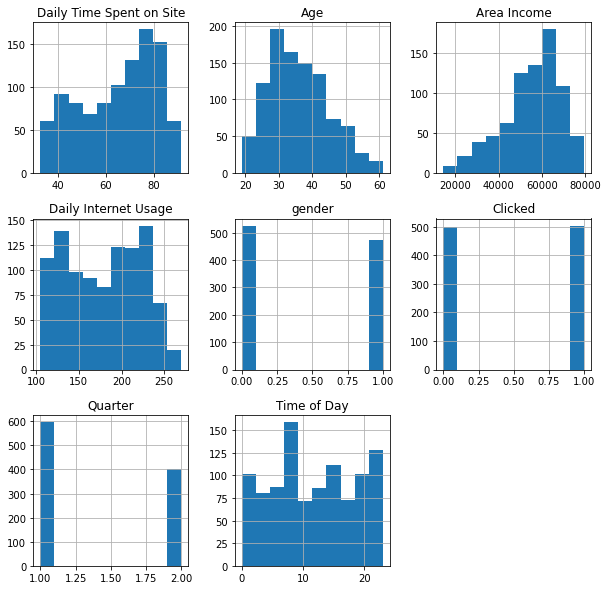

In [568]:
# create histograms of the numeric variables
data.select_dtypes(np.number).hist(figsize=(10,10));

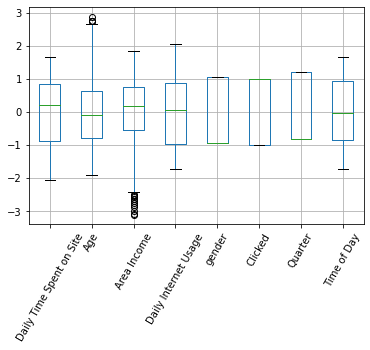

In [569]:
# create boxplots of the numeric variables
x = data.select_dtypes(np.number)
x_scaled = scale(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)
x_scaled.boxplot(rot=60);

* Age contains a small number of outliers in the upper tail of the distribution.
* Area Income contains several outliers in the lower tail of the distribution.

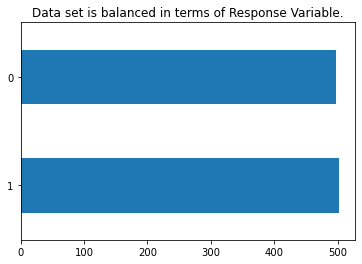

In [570]:
data['Clicked'].value_counts().plot(kind='barh', title = 'Data set is balanced in terms of Response Variable.');

The response variable, Clicked, appears to be uniformly distributed.

### Daily Time Spent on Site by Label

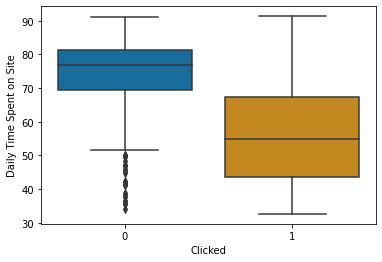

In [571]:
sns.boxplot(y = 'Daily Time Spent on Site', x = 'Clicked', data = data, palette='colorblind');

It would appear that those who clicked ads spent less time on the site on average on a given day. There appears to be a significant difference given that the IQR by groups do not overlap.

### Age by Label

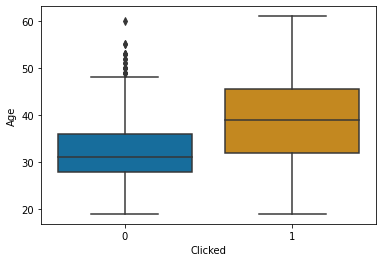

In [572]:
sns.boxplot(y = 'Age', x = 'Clicked', data = data, palette='colorblind');

Age may also have a relationship with Clicked in that those who were older tended to click on ads more than those who were younger.

### Area Income by Label

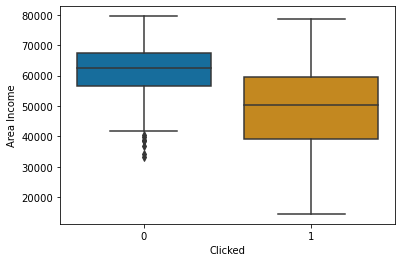

In [573]:
sns.boxplot(y = 'Area Income', x = 'Clicked', data = data, palette='colorblind');

Those who clicked on ads seem to generally be of a lower area income group. However, we saw that this variable has a substantial proportion of missing values (25%). Let's see how that missingness varies across classes of the response variable.

In [574]:
data['Area Income'].isna().groupby(data['Clicked'], sort=False).sum()

Clicked
0    110
1    115
Name: Area Income, dtype: int64

There are an equal number of missing values respective to each class.

### Daily Internet Usage by Label

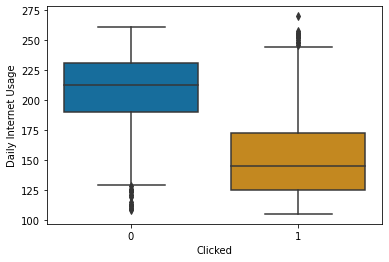

In [575]:
sns.boxplot(y = 'Daily Internet Usage', x = 'Clicked', data = data, palette='colorblind');

Similary to the time spent on the site, an individual who spent less time on the internet was also more likely to click the ad.

### Time of Day by Label

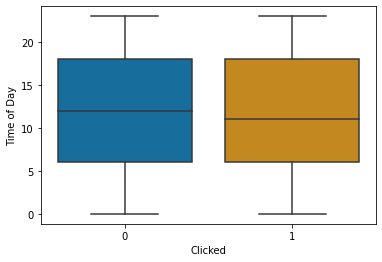

In [576]:
sns.boxplot(y = 'Time of Day', x = 'Clicked', data = data, palette='colorblind');

It would appear that time of day made no difference on whether an individual clicked an ad.

### Gender

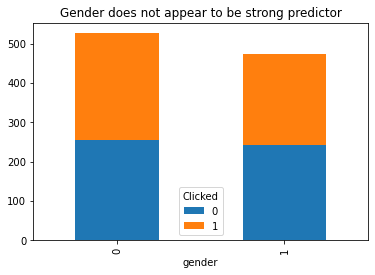

In [577]:
data.groupby(['gender','Clicked'])['gender'].count().unstack('Clicked').fillna(0).plot(kind='bar', stacked=True, title = 'Gender does not appear to be strong predictor');

### Country
Encodings to address high cardinality in the Country variable.

In [578]:
x=data['Country'].drop_duplicates().count()
print("Number of unique countries: {:d}".format(x))

Number of unique countries: 233


In [579]:
# By country, the proportion favoring clicked.
x = data.groupby(['Country','Clicked'])['Country'].count().unstack('Clicked').fillna(0)
# (1==100% favored click)
sort_order = (x[1] - x[0]) / x.sum(axis=1)
sort_order.sort_values(ascending=False)

Country
Dominican Republic    1.0
Slovenia              1.0
Lithuania             1.0
Macao                 1.0
Macedonia             1.0
                     ... 
Sri Lanka            -1.0
Sudan                -1.0
Tanzania             -1.0
Swaziland            -1.0
Greenland            -1.0
Length: 233, dtype: float64

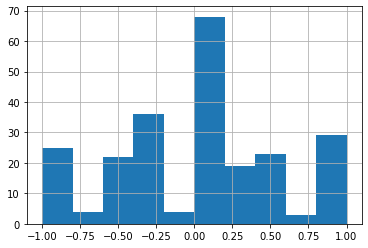

In [580]:
sort_order.hist();

Typically countries will not exhibit a preference for clicking or not clicking. However, as shown via the tails of the distribution there are about an small but equal proportion of countries that prefer one or the other.

Certain countries display extreme leaning (i.e. 100% observations) towards one class versus the other such as 'Ethiopia', 'Croatia', and about 50 other countries. Perhaps we can encode these country names within a new variable like 'click_preference' and give them the label 'strong', but categorize the others as 'weak'

In [581]:
def click_preference(x):
    """[function to help build country x-ref]

    Args:
        x ([float]): [proportion of records partitioned by country in favor of Clicked]

    Returns:
        [str]: [label]
    """
    if x >= -1 and x <= 1:
        if x == 1:
            out = 'strong'
        elif x == -1:
            out = 'weak'
        else:
            out = 'maybe'
        return out

In [582]:
# This dictionary serves to classify click preference label based on country
country_dict = sort_order.apply(click_preference).to_dict()

In [583]:
def get_country_label(country_name):
    """[function to apply to country variable in data]
    Depends on country_dict
    
    Args:
        country_name ([str]): [name of country]

    Returns:
        [str]: [click preference label]
    """
    try:
        return country_dict[country_name]
    except:
        return None

In [584]:
click_pref = data['Country'].apply(get_country_label)
data['Country Click Pref'] = click_pref.astype('category').cat.codes
data.drop('Country', 1, inplace=True)

In [585]:
# chi-square test between click preference and Clicked
a = pd.Categorical(data['Country Click Pref'])
b = pd.Categorical(data['Clicked'])
ct = pd.crosstab(a,b)
stat, p, dof, expected = chi2_contingency(ct)
print("Chi2: {:.2f} | p-value: {:.2f}".format(stat, p))

Chi2: 126.97 | p-value: 0.00


In [586]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,gender,Clicked,Quarter,Day of Week,Time of Day,Country Click Pref
id,,,,,,,,,,,
1200,80.67,34,58909.36,239.76,Seamless impactful info-mediaries,0,0,1,Friday,2,0
1201,68.01,25,68357.96,188.32,Ameliorated actuating workforce,1,0,1,Friday,3,0
1202,80.94,36,60803.00,239.94,Self-enabling local strategy,0,0,1,Friday,5,2
1203,78.77,28,63497.62,211.83,Public-key intangible Graphical User Interface,0,0,1,Friday,8,0
1204,36.56,29,42838.29,195.89,Team-oriented bi-directional secured line,0,1,1,Friday,15,1


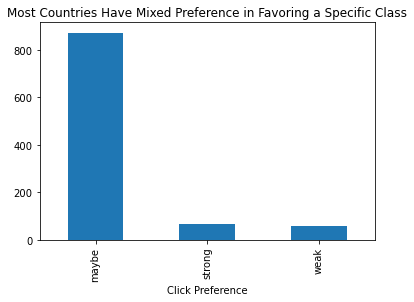

In [587]:
click_pref.value_counts().plot(kind='bar', title = 'Most Countries Have Mixed Preference in Favoring a Specific Class', xlabel='Click Preference');

### Day of Week
Shall we keep this variable?

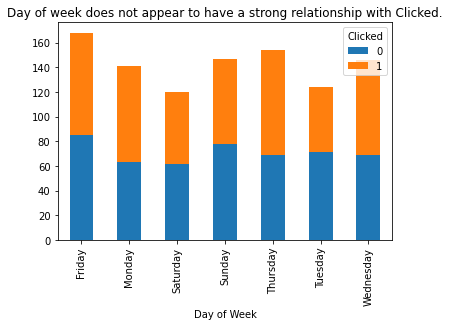

In [588]:
data.groupby(['Day of Week','Clicked'])['Day of Week'].count().unstack('Clicked').fillna(0).plot(kind='bar', stacked=True, title = 'Day of week does not appear to have a strong relationship with Clicked.');

In [589]:
# chi-square test between Day of Week and Clicked
a = pd.Categorical(data['Day of Week'])
b = pd.Categorical(data['Clicked'])
ct = pd.crosstab(a,b)
stat, p, dof, expected = chi2_contingency(ct)
print("Chi2: {:.2f} | p-value: {:.2f}".format(stat, p))

Chi2: 6.98 | p-value: 0.32


Day of week does not appear to have a significant relationship with the response variable. We should remove this variable.

In [590]:
data.drop('Day of Week', 1, inplace=True)

### Quarter
Shall we keep this variable?

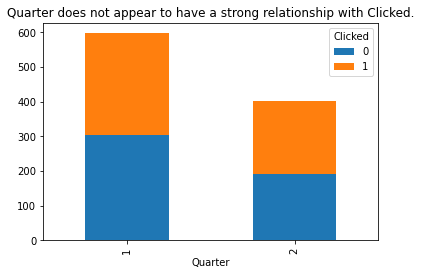

In [591]:
data.groupby(['Quarter','Clicked'])['Quarter'].count().unstack('Clicked').fillna(0).plot(kind='bar', stacked=True, title = 'Quarter does not appear to have a strong relationship with Clicked.');

In [592]:
# chi-square test between Quarter and Clicked
a = pd.Categorical(data['Quarter'])
b = pd.Categorical(data['Clicked'])
ct = pd.crosstab(a,b)
stat, p, dof, expected = chi2_contingency(ct)
print("Chi2: {:.2f} | p-value: {:.2f}".format(stat, p))

Chi2: 1.01 | p-value: 0.32


Quarter does not appear to have a significant relationship with the response variable. We should remove this variable.

In [593]:
data.drop('Quarter', 1, inplace=True)

In [594]:
# correlations between variables
num_vars = ['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage','Clicked','Time of Day']
data[num_vars].corr()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked,Time of Day
Daily Time Spent on Site,1.000000,-0.247097,0.324726,0.374857,-0.581175,-0.000697
Age,-0.247097,1.000000,-0.191739,-0.310589,0.370820,-0.025217
Area Income,0.324726,-0.191739,1.000000,0.343353,-0.479343,0.025362
Daily Internet Usage,0.374857,-0.310589,0.343353,1.000000,-0.589340,0.092216
Clicked,-0.581175,0.370820,-0.479343,-0.589340,1.000000,-0.051893
Time of Day,-0.000697,-0.025217,0.025362,0.092216,-0.051893,1.000000


People who clicked advertisements appear to be those who:
* spent a low amount of time on site 
* spent a low amount of time on the internet
* live in areas with lower average income
* were generally older in age

## Visualization, Modeling, Machine Learning

Predict which users might click a particular advertisement.
Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model's performance will be evaluated on the basis of accuracy.**
- **Read the test.csv file and prepare features for testing.**

In [595]:
data['Ad Topic Line'].sample(10)

id
1448            Enterprise-wide foreground emulation
1280     Vision-oriented contextually-based extranet
1698                     Robust transitional ability
2152          Public-key non-volatile implementation
1894    Reverse-engineered well-modulated capability
1964                   Total coherent superstructure
1600       Reverse-engineered content-based intranet
1629                        Ergonomic neutral portal
1684                  Exclusive zero tolerance frame
2149                    Networked local secured line
Name: Ad Topic Line, dtype: object

In [596]:
def clean_text(x):
    """[function to clean text]
    removes non-alphanumeric characters and lowers text
    Args:
        x ([str]): [a string]

    Returns:
        [str]: [clean string]
    """
    pattern = re.compile('[^a-zA-Z0-9]+')
    out = ' '.join(re.sub(pattern, ' ', x).lower().split())
    return out

In [597]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\white\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [598]:
def get_document_statistics(clean_str_list):
    """[function to compute and print document statistics]
    - avg characters per line
    - avg words per line
    - avg vocab per line
    - avg lexical richness per line
    Args:
        clean_str_list ([list]): [list of cleaned text strings]
    """
    docs = [word_tokenize(x) for x in clean_str_list]
    # avg number of characters per ad topic line
    avg_chars = int(sum([len(t) for t in texts]) / len(texts))
    print('Average number of characters per line: {:d}'.format(avg_chars))
    # average number of words per ad topic line
    avg_words = int(sum([len(doc) for doc in docs]) / len(docs))
    print('Average number of words per line: {:d}'.format(avg_words))
    # average vocabulary size per ad topic line
    avg_vocab = int(sum([len(set(doc)) for doc in docs]) / len(docs))
    print('Average vocabulary size per line: {:d}'.format(avg_vocab))
    # average lexical richness per line (proportion of unique words to total words)
    avg_lex_rich = sum([len(set(doc)) / len(doc) for doc in docs if len(doc) > 0]) / len(docs)
    print('Average lexical richness per line: {:.2f}'.format(avg_lex_rich))

In [599]:
# ad line text statistics of not-clicked ad topic lines
print('Text statistics for Ad Topic Lines that were not clicked')
texts = data.loc[data['Clicked']==0, 'Ad Topic Line'].apply(clean_text)
get_document_statistics(texts)

Text statistics for Ad Topic Lines that were not clicked
Average number of characters per line: 32
Average number of words per line: 3
Average vocabulary size per line: 3
Average lexical richness per line: 1.00


In [600]:
# ad line text statistics of not-clicked ad topic lines
print('Text statistics for Ad Topic Lines that were clicked')
texts = data.loc[data['Clicked']==1, 'Ad Topic Line'].apply(clean_text)
get_document_statistics(texts)

Text statistics for Ad Topic Lines that were clicked
Average number of characters per line: 33
Average number of words per line: 3
Average vocabulary size per line: 3
Average lexical richness per line: 1.00


In [601]:
def get_corpus_statistics(clean_str_list):
    """[function to compute and print document statistics]
    - total number of words
    - total vocab size
    - total lexical richness
    - avg chars per word
    Args:
        clean_str_list ([list]): [list of cleaned text strings]
    """
    docs = [word_tokenize(x) for x in clean_str_list]
    words = []
    for doc in docs:
        words.extend(doc)
    # total number of words
    print("Total number of words: {:d}".format(len(words)))
    # vocabulary size
    print("Total vocabulary size: {:d}".format(len(set(words))))
    # lexical richness
    print("Total lexical richness: {:.2f}".format(len(set(words)) / len(words)))
    # average number of characters per word
    word_lengths = [len(w) for w in words]
    print("Average number of characters per word: {:.2f}".format(sum(word_lengths) / len(word_lengths)))

In [602]:
# corpus statistics of not-clicked ad topic lines
print("Corpus level statistics for Ad Topic Lines that were not clicked")
texts = data.loc[data['Clicked']==0, 'Ad Topic Line'].apply(clean_text)
get_corpus_statistics(texts)

Corpus level statistics for Ad Topic Lines that were not clicked
Total number of words: 1964
Total vocabulary size: 341
Total lexical richness: 0.17
Average number of characters per word: 7.58


In [603]:
# corpus statistics of clicked ad topic lines
print("Corpus level statistics for Ad Topic Lines that were clicked")
texts = data.loc[data['Clicked']==1, 'Ad Topic Line'].apply(clean_text)
get_corpus_statistics(texts)

Corpus level statistics for Ad Topic Lines that were clicked
Total number of words: 1999
Total vocabulary size: 341
Total lexical richness: 0.17
Average number of characters per word: 7.70


Simple text statistics do not seem to distinguish between classes very well.

Frequency distributions for Ad Topic lines that were not clicked


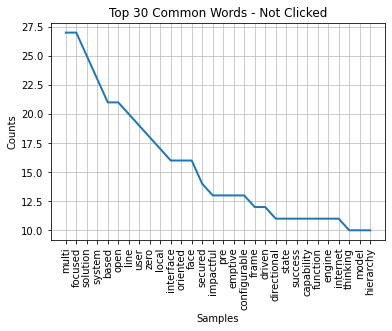

In [604]:
# Frequency distribution of not-clicked ad topic lines
print('Frequency distributions for Ad Topic lines that were not clicked')
texts = data.loc[data['Clicked']==0, 'Ad Topic Line'].apply(clean_text)
docs = [word_tokenize(x) for x in texts]
words = []
for doc in docs:
    words.extend(doc)
fdist_not_clicked = FreqDist(words)
fdist_not_clicked.plot(30, title = 'Top 30 Common Words - Not Clicked');

Frequency distributions for Ad Topic lines that were clicked


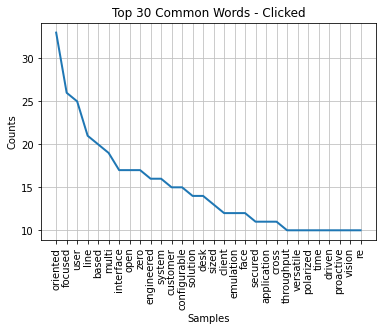

In [605]:
# Frequency distribution of clicked ad topic lines
print('Frequency distributions for Ad Topic lines that were clicked')
texts = data.loc[data['Clicked']==1, 'Ad Topic Line'].apply(clean_text)
docs = [word_tokenize(x) for x in texts]
words = []
for doc in docs:
    words.extend(doc)
fdist_clicked = FreqDist(words)
fdist_clicked.plot(30, title = 'Top 30 Common Words - Clicked');

Distributions of top terms appear similar between classes of the response variable.

### Vectorization, Clustering, LDA

In [606]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\white\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [607]:
from nltk.corpus import stopwords
# common english stopwords
stopwords = stopwords.words('english')

# vectorization
pattern = re.compile(r'[A-Za-z]+') # custom token pattern alphabetic words
vec = TfidfVectorizer(
    max_df = 0.95, min_df = 2, stop_words = stopwords,
    use_idf = True, norm = 'l2', token_pattern = pattern, ngram_range=(1,2)
)
dtm = vec.fit_transform(data['Ad Topic Line'])
feat_names = vec.get_feature_names()
print('Vocabulary size: {:d}'.format(len(feat_names)))
# convert to array
dtm_array = dtm.toarray()
# scale features
dtm_norm = scale(dtm_array)
# convert to dataframe
dtm_df = pd.DataFrame(dtm_array, columns = feat_names, index=data.index.values)
dtm_df.head()

Vocabulary size: 834


,ability,access,actuating,adapter,adaptive,adaptive hour,added,administration,administration instruction,administration neural,administration secured,administration success,advanced,advanced exuding,advanced systemic,algorithm,alliance,alone,alone eco,alone explicit,ameliorated,ameliorated client,ameliorated coherent,ameliorated exuding,ameliorated upward,analyzer,analyzing,analyzing concept,analyzing emulation,analyzing encryption,application,approach,architected,architected intangible,architected needs,architected system,architected zero,architecture,archive,area,area network,array,assimilated,assimilated hybrid,assimilated next,asymmetric,asymmetric emulation,asymmetric infrastructure,asynchronous,asynchronous application,...,universal empowering,universal incremental,upgradable,upgradable asymmetric,upgradable even,upward,upward trending,user,user centric,user facing,user friendly,user interface,utilization,value,value added,versatile,versatile local,versatile scalable,versatile solution,versatile thgeneration,virtual,virtual bandwidth,virtual executive,virtual impactful,virtual thgeneration,vision,vision oriented,visionary,volatile,volatile analyzer,volatile implementation,volatile neural,warehouse,web,web enabled,website,well,well modulated,wide,wide foreground,workforce,worthy,worthy forecast,worthy superstructure,worthy task,worthy toolset,zero,zero administration,zero defect,zero tolerance
1200,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1201,0.0,0.0,0.610504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1202,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1203,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.271766,0.0,0.0,0.0,0.349121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1204,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Top Text Features based on Mutual Information

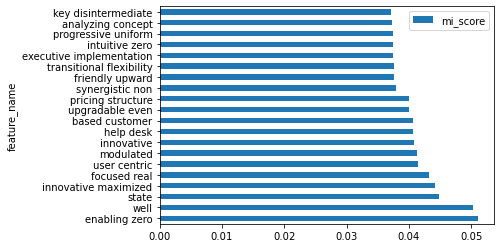

In [608]:
X = dtm_df
y = data.loc[:, 'Clicked']
mi = mutual_info_classif(X,y)
mi_df = pd.DataFrame({
    'feature_name': X.columns,
    'mi_score': mi
})

top_20_text_features = mi_df.sort_values(by = 'mi_score', ascending=False).head(20)
top_20_text_features.set_index('feature_name').plot(kind='barh');

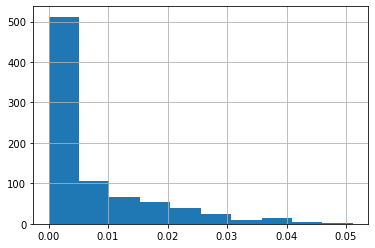

In [609]:
mi_df['mi_score'].hist();

The distribution of mutual information scores display a very tight range below 0.05. These features may not be very useful in distinguishing the response class variable.

C:\Users\white\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


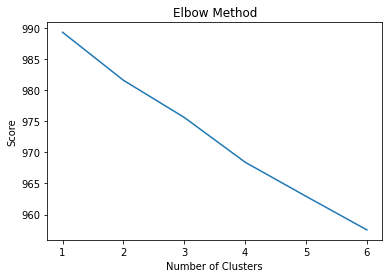

In [610]:
# finding optimal number of clusters
number_clusters = range(1,7)
kmeans = []
for k in number_clusters:
    kmeans.append(
        KMeans(
            n_clusters=k, algorithm='auto', init='random',
            n_init=20, random_state=1, verbose=False
        )
    )
score = [kmeans[i].fit(dtm_df).inertia_ for i in range(len(kmeans))]
# plot Elbow Method
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

The optimal number of clusters is not very apparent using the KMeans algorithm. Next we'll try clustering with DBSCAN.
* eps (epsilon radium) = 0.7
* min_samples = 2

In [611]:
db = DBSCAN(eps=0.7, min_samples=2).fit(dtm_df)
# define the indices where dbscan was able to cluster the points
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
np.unique(core_samples_mask, return_counts = True)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: {:d}'.format(n_clusters_))
db_df = pd.DataFrame({
    'cluster':labels,
    'Clicked':data['Clicked']
})
print('Number not assigned to cluster: {:d}'.format(db_df[db_df['cluster']==-1].shape[0]))
db_df.value_counts()

Estimated number of clusters: 197
Number not assigned to cluster: 605


cluster  Clicked
-1       0          306
         1          299
 60      1            2
 94      0            2
 96      1            2
                   ... 
 112     1            1
 113     0            1
         1            1
 35      0            1
 196     1            1
Length: 278, dtype: int64

In [612]:
# LDA (latent dirischelet allocation)
num_topics = 20
lda = LatentDirichletAllocation(
    n_components=num_topics, max_iter=5,
    learning_method='online', learning_offset=50,
    random_state=0
)
lda_z = lda.fit_transform(dtm_df)

# function to display topics
def display_topics(model, feature_names, top_n):
    for idx, topic in enumerate(model.components_):
        print("Topic {:d}:".format(idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]]))
display_topics(model = lda, feature_names=feat_names, top_n=10)

Topic 0:
context sensitive sensitive context roots grass roots grass synergized asymmetric customizable workforce
Topic 1:
intermediate analyzing forecast oriented team oriented team analyzing emulation initiative progressive local forecast
Topic 2:
solution next next generation generation internet solution internet group engine system engine cross
Topic 3:
knowledge knowledge user thgeneration dedicated full full range polarized range user versatile
Topic 4:
desk even keeled even keeled service desk service stand alone stand alone distributed
Topic 5:
disintermediate tolerance sized zero tolerance right sized right zero groupware solution public key
Topic 6:
assimilated secondary discrete universal incremental discrete extranet incremental array operative secondary secondary functionalities switchable secondary secondary ability
Topic 7:
non volatile non volatile human human resource resource info mediaries info mediaries challenge
Topic 8:
line front line front business focused busin

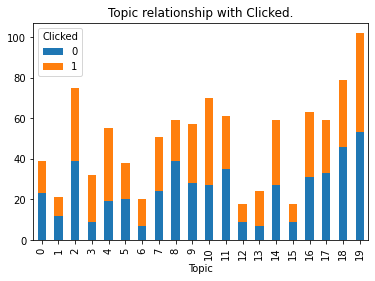

In [613]:
# documents across different topic spaces
docs_vs_topics = pd.DataFrame(lda_z, index=dtm_df.index.values)
#docs_vs_topics
most_likely_topics = docs_vs_topics.idxmax(axis=1)
most_likely_topics.groupby(most_likely_topics).count()
docs_vs_topics['Clicked'] = data['Clicked'].values
docs_vs_topics['Topic'] = most_likely_topics
# plot topics by Clicked
docs_vs_topics.groupby(['Topic','Clicked'])['Topic'].count().unstack('Clicked').fillna(0).plot(kind='bar', stacked=True, title = 'Topic relationship with Clicked.');

In [614]:
# chi-square test between Quarter and Clicked
a = pd.Categorical(docs_vs_topics['Topic'])
b = pd.Categorical(docs_vs_topics['Clicked'])
ct = pd.crosstab(a,b)
stat, p, dof, expected = chi2_contingency(ct)
print("Chi2: {:.2f} | p-value: {:.2f}".format(stat, p))

Chi2: 34.09 | p-value: 0.02


In [615]:
# which topics display most relationship with response?
x = (ct / expected)
abs(x[1] - x[0]).sort_values(ascending=False).head()

row_0
3     0.863031
13    0.821363
8     0.656091
4     0.606204
6     0.588021
dtype: float64

Unsupervised approaches indicate that the Ad Topic Line may not be very predictive of the response variable. However, topic modeling does seem to indicate a relationship between topics and whether the user clicked based on a significant chi-square statistic, particularly for topics 3 and 13 in this case. However, for the purpose of classification it may not be feasible to rely on an unsupervised technique to generate predictors. Therefore, we'll drop the text column and and its derivatives for now.

In [616]:
# removing Ad Topic Line variable
data.drop('Ad Topic Line', 1, inplace=True)
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,gender,Clicked,Time of Day,Country Click Pref
id,,,,,,,,
1200,80.67,34,58909.36,239.76,0,0,2,0
1201,68.01,25,68357.96,188.32,1,0,3,0
1202,80.94,36,60803.00,239.94,0,0,5,2
1203,78.77,28,63497.62,211.83,0,0,8,0
1204,36.56,29,42838.29,195.89,0,1,15,1


Now to address the missingness in Area Income, we'll use KNN Imputation to fill in values with estimates based on similar observations.

In [617]:
# Recall that Area Income had about 22.5% missing values
data.isna().sum()

Daily Time Spent on Site      0
Age                           0
Area Income                 225
Daily Internet Usage          0
gender                        0
Clicked                       0
Time of Day                   0
Country Click Pref            0
dtype: int64

In [618]:
data.dtypes

Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
gender                        int64
Clicked                       int64
Time of Day                   int64
Country Click Pref             int8
dtype: object

### Scale and Impute Missing Values

In [721]:
# separate predictors and label
X = data.loc[:, data.columns != 'Clicked']
y = data['Clicked']

# subset columns
keep = ['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage','gender','Country Click Pref','Time of Day']
X = X[keep]

# scale variables and impute missing values in dataset
imputer = KNNImputer(n_neighbors=20, weights='uniform')
X = pd.DataFrame(imputer.fit_transform(scale(X)), columns=X.columns)

# one final check for missing values
X.isna().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
gender                      0
Country Click Pref          0
Time of Day                 0
dtype: int64

### Checking for Multicollinearity

In [722]:
variables = list(range(X.shape[1]))
vif = [
    variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in range(X.iloc[:, variables].shape[1])
]
vif_df = pd.DataFrame({'variable': X.columns, 'vif': vif})

# exclude features with high variance inflation factors
keep = X.columns[~vif_df['vif'].isin([np.inf])]
X = X[keep]

vif_df

,variable,vif
0,Daily Time Spent on Site,1.253135
1,Age,1.136830
2,Area Income,1.212608
3,Daily Internet Usage,1.331631
4,gender,1.003512
5,Country Click Pref,1.011583
6,Time of Day,1.011917


### Feature Importance using recursive feature elimination

In [723]:
# implementing the model
# exogenous variable is one whose value is determined outside the model i.e. X
# endogenous variable is one whoe value is determined by the model i.e. y
logit_model = sm.Logit(list(y), X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.372191
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.463      
Dependent Variable:    y                  AIC:                758.3817   
Date:                  2021-09-07 00:14   BIC:                792.7359   
No. Observations:      1000               Log-Likelihood:     -372.19    
Df Model:              6                  LL-Null:            -693.13    
Df Residuals:          993                LLR p-value:        2.1516e-135
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        6.0000                                            
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Daily Time Spent on Site -1.1278   0.104

### Exclude Insignificant Features

In [724]:
excl = ['gender','Time of Day','Country Click Pref']
keep = X.columns[~X.columns.isin(excl)]
X = X[keep]

logit_model = sm.Logit(list(y), X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.374446
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.460      
Dependent Variable:    y                  AIC:                756.8919   
Date:                  2021-09-07 00:14   BIC:                776.5229   
No. Observations:      1000               Log-Likelihood:     -374.45    
Df Model:              3                  LL-Null:            -693.13    
Df Residuals:          996                LLR p-value:        7.9880e-138
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        6.0000                                            
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Daily Time Spent on Site -1.1280   0.103

In [725]:
# Logistic Regression Model Fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
logreg = LogisticRegression(C=1e8) # negate regularization effect that sklearn applies to logistic regression
logreg.fit(X_train, y_train)

LogisticRegression(C=100000000.0)

In [726]:
# prediction of sample test set
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


[[140  18]
 [ 25 117]]


Text(0.5, 257.44, 'Predicted label')

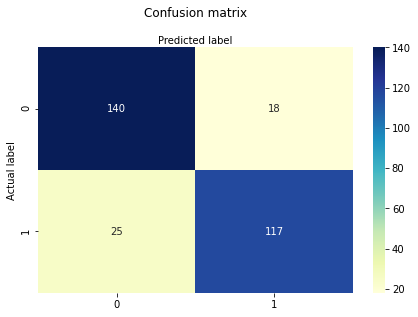

In [699]:
# Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)
print(cmatrix)
# plot heatmap
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cmatrix), annot=True, cmap = "YlGnBu", fmt = 'g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [700]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       158
           1       0.87      0.82      0.84       142

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



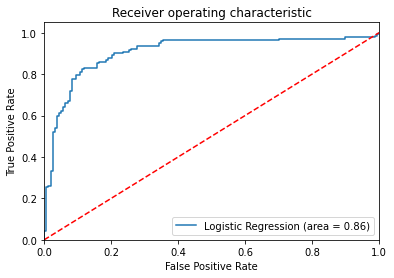

In [701]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc='lower right')
#plt.savefig('Log_ROC')
plt.show()

The ROC curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible.

### K-fold Cross-Validation

In [702]:
# perform a 10-fold cross-validation and average the accuracy scores
cv = KFold(random_state=1, shuffle=True, n_splits=10)
model = LogisticRegression()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=1)
print('Scores:', scores)
print('Accuracy: %.3f | Standard Dev %.3f' % (np.mean(scores), np.std(scores)))

Scores: [0.88571429 0.78571429 0.85714286 0.84285714 0.88571429 0.87142857
 0.85714286 0.88571429 0.85714286 0.84285714]
Accuracy: 0.857 | Standard Dev 0.029


### Interpretation of the Coefficients

In [703]:
mod = sm.Logit(list(y_train), X_train)
result_mod = mod.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.372665
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.460      
Dependent Variable:    y                  AIC:                756.8919   
Date:                  2021-09-06 23:58   BIC:                776.5229   
No. Observations:      1000               Log-Likelihood:     -374.45    
Df Model:              3                  LL-Null:            -693.13    
Df Residuals:          996                LLR p-value:        7.9880e-138
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        6.0000                                            
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Daily Time Spent on Site -1.1280   0.103

Per the above summary, the coefficients represent the log-odds of the effect the variables have on Clicked. If we convert these log-odds to plain-odds, we get:

In [704]:
var_names = X_train.columns.values
odds = np.exp(logreg.coef_)[0]
list(zip(var_names, odds))

[('Daily Time Spent on Site', 0.3351970142301521),
 ('Age', 1.8523787166980987),
 ('Area Income', 0.5928408070758107),
 ('Daily Internet Usage', 0.36780826612479567)]

* A one unit increase in Daily Time Spent on Site results in a 0.33:1 (67%) decrease in the odds that an ad will be clicked.
* A one unit increase in Age results in 1.85:1 (85%) increase in the odds that an ad will be clicked.
* A one unit increase in Area Income results in a 0.59:1 (41%) decrease in the odds that an ad will be clicked.
* A one unit increase in Daily Internet Usage results in a 0.37:1 (63%) decrease in the odds that an ad will be clicked.

### Deployment

In [ ]:
# create pipeline


In [706]:
# Save model
pickle.dump(logreg, open('output/logistic_regression.sav', 'wb'))

# Predicting the Test Set

In [750]:
#Loading Test data
X_test=pd.read_csv('test.csv').set_index('id')
print("Test data shape:", X_test.shape)
X_test.head()

Test data shape: (300, 8)


,Timestamp,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,gender,Country
id,,,,,,,,
2200,2016-06-04 17:24:07,43.88,54,31523.09,166.85,Enhanced methodical database,1,Somalia
2201,2016-06-05 00:29:13,66.40,40,77567.85,214.42,Digitized heuristic solution,0,Antigua and Barbuda
2202,2016-06-05 00:29:13,79.52,34,NaN,141.58,Customer-focused 24/7 concept,0,United States of America
2203,2016-06-05 07:54:30,52.35,25,33293.78,147.61,Mandatory 4thgeneration structure,1,Mali
2204,2016-06-05 07:54:30,81.51,36,NaN,195.93,Monitored local Internet solution,0,Croatia


### Transform data

In [751]:
# feature extraction of time of day
date_pattern='%Y-%m-%d'
time_pattern='%H:%M:%S'
full_pattern = ' '.join([date_pattern, time_pattern])

X_test['Time of Day'] = pd.to_datetime(X_test['Timestamp'], format = full_pattern).dt.hour
X_test.drop('Timestamp',1, inplace=True)

In [752]:
# Encode country click preference
click_pref = X_test['Country'].apply(get_country_label)
X_test['Country Click Pref'] = click_pref.astype('category').cat.codes
X_test.drop('Country', 1, inplace=True)

In [753]:
# subset to relevant variables for KNN impute of missing values
keep = ['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage','gender','Time of Day','Country Click Pref']
X_test = X_test[keep]
# scale variables and impute missing values in dataset
imputer = KNNImputer(n_neighbors=20, weights='uniform')
X_test = pd.DataFrame(imputer.fit_transform(scale(X_test)), columns=X_test.columns, index=X_test.index.values)
# final subset of features
keep = ['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage']
X_test = X_test[keep]
X_test.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
2200,-1.334717,2.010123,-1.578961,-0.391373
2201,0.083614,0.457048,1.681929,0.710656
2202,0.909924,-0.208556,0.061806,-0.976790
2203,-0.801269,-1.206961,-1.453561,-0.837096
2204,1.035256,0.013312,0.444150,0.282308


### Load Model

In [754]:
# filename for stored logistic regression model
fname = 'output/logistic_regression.sav'
logreg = pickle.load(open(fname, 'rb'))
type(logreg)

sklearn.linear_model._logistic.LogisticRegression

### Predict New Data

In [755]:
y_pred = logreg.predict(X_test)
submission = pd.DataFrame({
    'id': X_test.index.values,
    'Clicked': y_pred
})
submission.head(10)

,id,Clicked
0,2200,1
1,2201,0
2,2202,1
3,2203,1
4,2204,0
5,2205,0
6,2206,0
7,2207,1
8,2208,0
9,2209,0




**Describe the most important features in the model to a management audience.**

> #### Task:
- **Visualize the top 10 features and their feature importance.**


Feature: Daily Time Spent on Site, Score: -1.09304
Feature: Age, Score: 0.61647
Feature: Area Income, Score: -0.52283
Feature: Daily Internet Usage, Score: -1.00019


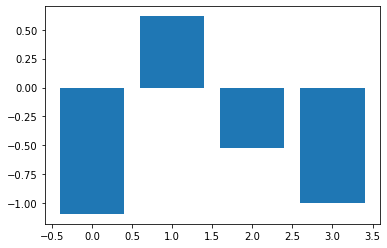

In [758]:
# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: {:s}, Score: {:.5f}'.format(X_test.columns[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict whether a consumer clicked on an ad or not. Submit a CSV file with a header row and one row per test entry. 
    
The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **Clicked**

In [759]:
submission.head(10)

,id,Clicked
0,2200,1
1,2201,0
2,2202,1
3,2203,1
4,2204,0
5,2205,0
6,2206,0
7,2207,1
8,2208,0
9,2209,0


In [760]:
# write submission to csv
submission.to_csv('output/submissions.csv')